In [8]:
import gzip
import numpy as np
import pandas as pd
import time
import os
from utils import *
from orderbook import OrderBook
from spectrum import Spectrum
import matplotlib.pyplot as plt
import numpy as np


# Reading
WORKING_DIR = r"D:\Data\MOEX-FX\2018-03\\"
orderlog_filename = WORKING_DIR + 'OrderLog20180301.txt'
order_log = read_orderlog(orderlog_filename)
# preprocesiing
order_log = preprocess_orderlog(order_log)


SECCODES = ['USD000UTSTOM']

# creating order book for each seccode
order_books = dict()
for secc in SECCODES:
    order_books[secc] = OrderBook(secc)

# creating spectrum for each seccode
spectrums = dict()
for secc in SECCODES:
    spectrums[secc] = Spectrum(seccode=secc)

start = time.time()

list_spec = []
col_names = ['SECCODE', 'TIMESTAMP', 'BID_ASK']
do_spec = True
# FOR TASK 6
mp_increments = []
BEST_BID = -1
BEST_ASK = 1e19
prev = -1e19

for row_log in order_log:
    
    if row_log['SECCODE'] not in SECCODES:
        continue
        
    if instruments_info[row_log['SECCODE']]['SCHEDULE'] <= row_log['TIME']:
        continue

    is_ask = row_log['BUYSELL'] == 'S'

    order_book = order_books[row_log['SECCODE']]
    spectrum = spectrums[row_log['SECCODE']]
    correct = False

    # CATCHING AGGRESSORS
    if row_log['PRICE'] == 0:
        continue
    if is_ask:
        if spectrum.best_bid > 0 and row_log['PRICE'] <= spectrum.best_bid:
            continue
    else:
        if spectrum.best_ask < 1e19 and row_log['PRICE'] >= spectrum.best_ask:
            continue

    # handle post
    if row_log['ACTION'] == Action.POST:
        order_book.add_entry(entry=row_log, 
                             ask=is_ask)
        if do_spec:
            spectrum.update_post(order_book=order_book, new_price=row_log['PRICE'], 
                             volume=row_log['VOLUME'], ask=is_ask)

        correct = True

    # handle revoke
    elif row_log['ACTION'] == Action.REVOKE:
        correct = order_book.revoke(orderno=row_log['ORDERNO'], volume=row_log['VOLUME'], 
                          ask=is_ask, row_numb=row_log['NO'])
        if do_spec and correct:
            spectrum.update_revoke(order_book=order_book, new_price=row_log['PRICE'], 
                             volume=row_log['VOLUME'], ask=is_ask)

    elif row_log['ACTION'] == Action.MATCH:
        correct = order_book.match(orderno=row_log['ORDERNO'], volume=row_log['VOLUME'], 
                          ask=is_ask, row_numb=row_log['NO'])
        if do_spec and correct:
            spectrum.update_match(order_book=order_book, new_price=row_log['PRICE'], 
                             volume=row_log['VOLUME'], ask=is_ask)

    # TASK 6
    if do_spec and correct:
        if spectrum.best_bid == BEST_BID:
            mid_px = spectrum.best_ask
        elif spectrum.best_ask == BEST_ASK:
            mid_px = spectrum.best_bid
        else:
            mid_px = (spectrum.best_bid + spectrum.best_ask) / 2
            
        if prev == -1e19:
            incr = 0
        else:
            incr = mid_px - prev
        
        prev = mid_px
            
            
        mp_increments.append(incr)



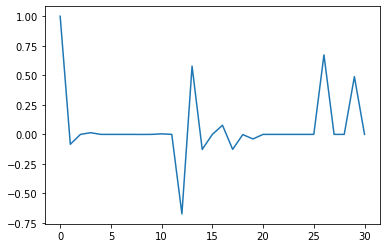

0 1.0


In [9]:
avg = sum(mp_increments) / len(mp_increments)
X = [0] * 31
X[0] = [increment - avg for increment in mp_increments]

for i in range(1, 31):
    X[i] = X[0][i:]
    
    

x0 = 0
y0 = np.corrcoef(X[0], X[0])[0][1]

x = [x0] + list(range(1, 31))
y = [y0] + [np.corrcoef(X[0][:-i], X[i])[0][1] for i in range(1, 31)]
plt.plot(x, y)
plt.show()

print(x0, y0)